In [1]:
import numpy as np
import pandas as pd
from tsfresh import feature_extraction
import os
import seaborn as sns
import re
from collections import defaultdict

In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

In [3]:
def normalize_signal(signal):
    """
    time_series
    
    Returns normalized TS: (TS - mean(TS))/std(TS)
    """
    std = np.std(signal)
    norm_signal = (signal - np.mean(signal)) / std if std else 1
    return norm_signal

In [4]:
def normalize_all_signals_in_ds(one_group_ds):
    for signal in one_group_ds.drop('t', axis=1):
        one_group_ds[signal] = normalize_signal(one_group_ds[signal])

In [5]:
# os.chdir('..')
os.getcwd()

'/Users/aolen/master_degree'

In [6]:
labels = pd.DataFrame(columns=['id', 'class', 'label'])
labels.columns
labels.append((pd.Series( [1, 2, 3], index=labels.columns)), ignore_index=True)
# dfObj.append(pd.Series(['Raju', 21, 'Bangalore', 'India'], index=dfObj.columns ), ignore_index=True)

,id,class,label
0,1,2,3


In [7]:
def append_signals_dataset(data_directory, signals_dataset = None, labels = None):
    data_dir_list = os.listdir(data_directory)
    os.chdir(data_directory)
    signal_id = 0
    if not labels:
        labels = pd.DataFrame(columns=['id', 'class', 'label'])
    for signal_label, directory in enumerate(data_dir_list):
        os.chdir(directory)
        for filename in os.listdir(os.curdir):
            if re.match(r'(.*csv)', filename):
                if (signals_dataset) is not None:
                    tmp_df = pd.read_csv(filename)
                    normalize_all_signals_in_ds(tmp_df)
                    tmp_df['id'] = signal_id
                    signals_dataset = signals_dataset.append(tmp_df, ignore_index=True)
                else:
                    signals_dataset = pd.read_csv(filename)
                    normalize_all_signals_in_ds(signals_dataset)
                    signals_dataset['id'] = 0
#                 print(signals_dataset.head(5))
                tmp_labels = pd.Series([signal_id, directory, np.int(signal_label)],
                                         index=labels.columns)
                labels = labels.append(tmp_labels, ignore_index=True)
                signal_id += 1
        os.chdir('../')
    os.chdir('../')
    return signals_dataset, labels

In [8]:
ex = pd.read_csv('./data/le_8/1.csv')
ex2 = pd.read_csv('./data/le_8/2.csv')
ex3 = pd.read_csv('./data/more_8/2.csv')

Data preprocessing:
    - dropping U.1 == U
    - changing type
    - generating features

In [9]:
dataset, labels = append_signals_dataset('./data')

In [10]:
# converting data in labels dataframe
labels.label = pd.to_numeric(labels.label)

In [11]:
# Check if data merging with labels
mod_dataset = dataset.drop(['U.1', 'Pgt'], axis=1)
mod_dataset.merge(labels, on='id')

,t,U,Pij,Pg,delta,id,class,label
0,0.01,0.980952,-0.273585,0.657965,-0.953874,0,le_8,0
1,0.02,0.980952,-0.273585,0.657965,-0.953874,0,le_8,0
2,0.03,0.980952,-0.273585,0.657965,-0.953874,0,le_8,0
3,0.04,0.980952,-0.273585,0.657965,-0.953874,0,le_8,0
4,0.05,0.980952,-0.273585,0.657965,-0.953874,0,le_8,0
...,...,...,...,...,...,...,...,...
7432,1.96,-1.107748,0.546772,0.863101,1.072291,36,more_8,1
7433,1.97,-1.094790,0.547869,0.862314,1.064166,36,more_8,1
7434,1.98,-1.088311,0.549333,0.861527,1.056041,36,more_8,1
7435,1.99,-1.075353,0.550431,0.860739,1.046562,36,more_8,1


In [12]:
dataset.id.describe()

count    7437.000000
mean       18.000000
std        10.677796
min         0.000000
25%         9.000000
50%        18.000000
75%        27.000000
max        36.000000
Name: id, dtype: float64

In [13]:
features = defaultdict()
for param in mod_dataset.loc[:,'U':'delta']:
    features[param] = feature_extraction.extract_features\
    (dataset.loc[:,[param,'id','t']], column_sort='t', column_id='id')

Feature Extraction: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


### После обработки каждого сигнала библиотекой tsfresh извлекаем всевозможные признаки, признаки классифицированы по сигналу, из которого были получены (словарь features)
В конечном счете для каждого сигнала сформирован следующий набор данных:

In [14]:
for param in features:
    print("Для параметра", param, "получено", features[param].shape[1], "признака(ов).")

Для параметра U получено 754 признака(ов).
Для параметра Pij получено 754 признака(ов).
Для параметра Pg получено 754 признака(ов).
Для параметра delta получено 754 признака(ов).


In [15]:
# Пример хранящихся признаков
features['U'].index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36],
           dtype='int64', name='id')

## Поиск наиболее важных признаков, которые позволят предсказывать результат переходного процесса

In [16]:
# Удаляем фичи количество признаков в которых меньше количества классов
def clear_useless_features(features, threshold=2):
    for feature in features.columns:
        if features[feature].nunique() <= threshold:
            features = features.drop(feature, axis=1)
    return features

In [17]:
modified_features = defaultdict()
for param in features:
    modified_features[param] = clear_useless_features(features[param],
                                                     labels.label.nunique())
    print(f"Число удаленных признаков для {param}:",
          features[param].shape[1] - modified_features[param].shape[1])

Число удаленных признаков для U: 72
Число удаленных признаков для Pij: 72
Число удаленных признаков для Pg: 68
Число удаленных признаков для delta: 70


Поиск признаков, имеющих наибольшую корреляцию с целевой переменной sklearn (Только для регресии и неотрицательных признаков)

In [18]:
def delete_negative_features(X):
    for i in X.columns:
        if X[i].min() < 0:
            X = X.drop(i, axis=1)
    return X

In [22]:
X = delete_negative_features(modified_features['U'])
y = labels.label
# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(X, labels.label)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))

Использование дерева для поиска фич

In [33]:
def plot_features(X, Y):
#     X = modified_features['U']
#     y = labels.label
    model = ExtraTreesClassifier(n_estimators=100)
    model.fit(X,y)
#     print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    plt.show()
    return feat_importances.nlargest(15)

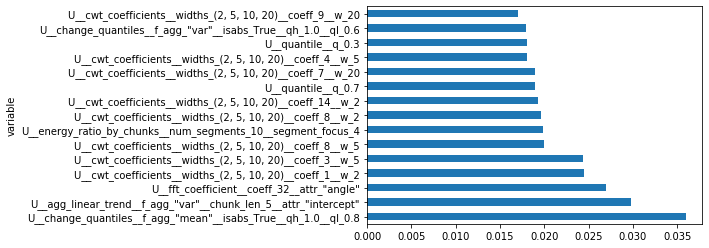

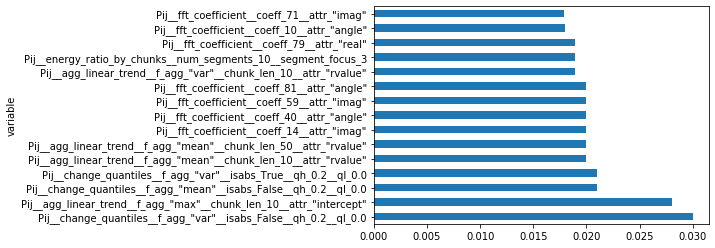

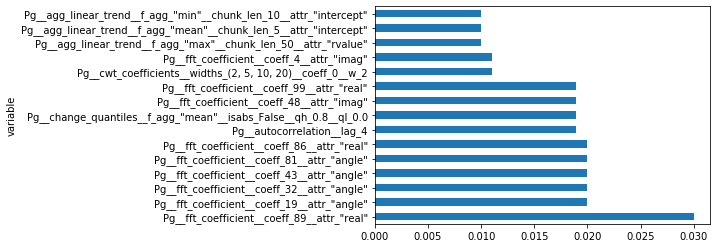

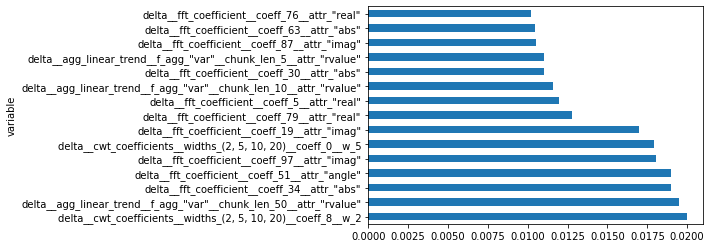

In [95]:
most_valuable_feat = dict([[feat, None] for feat in features])
for param in features:
    most_valuable_feat[param] = (plot_features(modified_features[param], labels.label))

In [110]:
# Создаем датафрэйм с индексами, который будем доплнять самыми релевантными фичами
resulted_df = pd.DataFrame(index=features['U'].index)
# Дополняем датафрэйм
for param in features:
    for feat in features[param]:
        if feat in most_valuable_feat[param]:
            if most_valuable_feat[param][feat] >= 0.018:
                resulted_df = resulted_df.join(features[param][feat])

In [113]:
# Выведем первые две строки получившегося датафрэйма
resulted_df.head(2)

,"U__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""intercept""","U__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8","U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_2","U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_2","U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_5","U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_5","U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_20","U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_2","U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_5",U__energy_ratio_by_chunks__num_segments_10__segment_focus_4,...,"Pg__fft_coefficient__coeff_48__attr_""imag""","Pg__fft_coefficient__coeff_81__attr_""angle""","Pg__fft_coefficient__coeff_86__attr_""real""","Pg__fft_coefficient__coeff_89__attr_""real""","Pg__fft_coefficient__coeff_99__attr_""real""","delta__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","delta__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_2","delta__fft_coefficient__coeff_34__attr_""abs""","delta__fft_coefficient__coeff_51__attr_""angle""","delta__fft_coefficient__coeff_97__attr_""imag"""
id,,,,,,,,,,,,,,,,,,,,,
0,-0.002031,0.007569,-0.007957,0.546674,0.953514,1.101949,1.163310,0.001427,0.792905,0.018130,...,-2.453813,-15.838641,2.286901,2.019802,2.045003,0.346967,-0.001388,4.020677,134.915484,0.112851
1,-0.000122,0.007759,-0.008111,0.534887,0.932789,1.077889,1.137548,0.001396,0.773725,0.016772,...,-3.112764,-12.965097,2.893002,2.114282,2.187433,0.297388,-0.001631,3.564345,135.165235,0.099831


In [112]:
print("Оставшиеся фичи:")
resulted_df.columns

Оставшиеся фичи:


Index(['U__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"intercept"',
       'U__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8',
       'U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_2',
       'U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_2',
       'U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_5',
       'U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_5',
       'U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_20',
       'U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_2',
       'U__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_5',
       'U__energy_ratio_by_chunks__num_segments_10__segment_focus_4',
       'U__fft_coefficient__coeff_32__attr_"angle"', 'U__quantile__q_0.3',
       'U__quantile__q_0.7',
       'Pij__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
       'Pij__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"',
       'Pij__agg_linear_trend__f_agg_"mean"__chunk_len_50

Построим тепловую карту фич, взятых из предыдущего шага

In [ ]:
# data = features['U'].iloc[:,0:50].join(labels.loc[:,['label']], on='id')

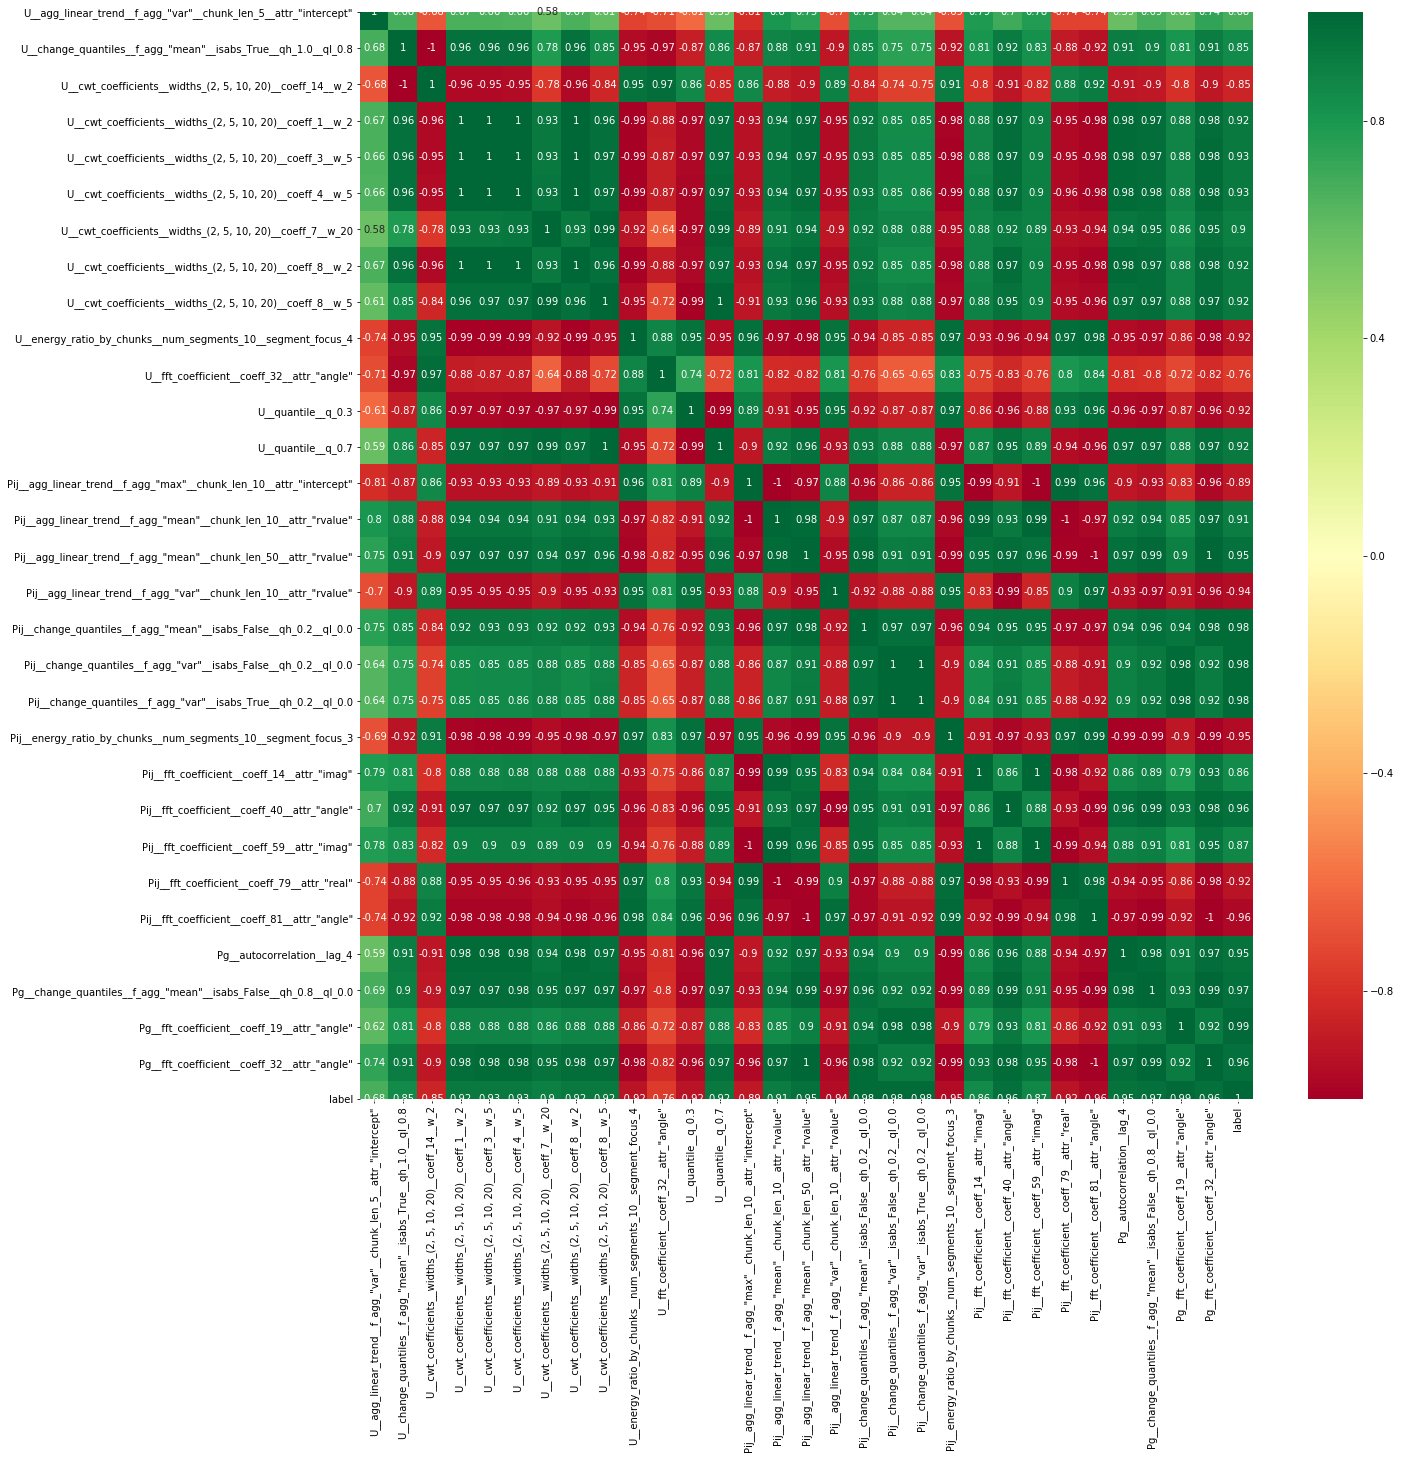

In [116]:
## get correlations of each features in dataset
data = resulted_df.iloc[:,:30].join(labels.loc[:,['id', 'label']])
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Постоение простейших моделей, градиентный бустинг и ансаамбль решающих деревьев

In [133]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [120]:
X_train, X_test, y_train, y_test = train_test_split(resulted_df, labels.label, test_size=0.2, random_state=42)

### Ансамбль решающих деревьев

In [161]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5, max_features=0.6)
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
scores

array([1., 1., 1., 1., 1.])

In [162]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [169]:
y_pred = clf.predict_proba(X_test)
y_scores = y_pred[:,1]
y_scores

array([0.67, 0.  , 0.  , 0.99, 1.  , 1.  , 0.  , 1.  ])

In [172]:
y_true = np.array(y_test)
metrics.roc_auc_score(y_true, y_scores)

1.0

### Градиентный бустинг

In [174]:
clf = GradientBoostingClassifier(learning_rate=0.01, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
scores

array([1., 1., 1., 1., 1.])

In [175]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [176]:
y_pred = clf.predict_proba(X_test)
y_scores = y_pred[:,1]
y_scores

array([0.69901972, 0.18978865, 0.18978865, 0.81085034, 0.82281622,
       0.82281622, 0.18978865, 0.82281622])

In [178]:
y_true = np.array(y_test)
metrics.roc_auc_score(y_true, y_scores)

1.0

Гит комит

In [179]:
!git status
!git add .
!git commit -m "feature extraction added"


error: key does not contain a section: name
error: key does not contain a section: email
error: key does not contain a section: name
error: key does not contain a section: email
On branch master
Your branch is up-to-date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)

	modified:   Data_processing.ipynb
	modified:   tsfresh (untracked content)

no changes added to commit (use "git add" and/or "git commit -a")
error: key does not contain a section: name
error: key does not contain a section: email
error: key does not contain a section: name
error: key does not contain a section: email
error: key does not contain a section: name
error: key does not contain a section: email
[master aea26ae] feature extraction added
 1 file changed, 1321 insertions(+), 798 deletions(-)
 rewrite Da